In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [8]:
df_half_hour=pd.read_csv('daily_max_temp_HECA.csv')
df_half_hour.isna().sum()

relh          0
drct          0
sknt          0
alti          0
vsby          0
temp_c        0
dewpoint_c    0
feel_c        0
dtype: int64

In [11]:
filter_df=df_half_hour
daily_max_temp=filter_df

In [14]:
percentile_90 = np.percentile(daily_max_temp['temp_c'], 90)
print(f"90th Percentile of max_temp_c: {percentile_90}")
daily_max_temp

90th Percentile of max_temp_c: 36.0


,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c
0,41.42,200,4.0,30.060,6.21,25.0,11.0,25.000000
1,33.85,230,11.0,30.000,1.86,25.0,8.0,24.438889
2,53.03,280,4.0,30.030,6.21,22.0,12.0,22.000000
3,59.97,280,5.0,30.090,6.21,20.0,12.0,20.000000
4,49.37,40,11.0,30.090,6.21,21.0,10.0,21.000000
...,...,...,...,...,...,...,...,...
5402,41.19,330,8.0,29.925,6.21,29.0,14.5,28.719444
5403,42.52,10,7.0,29.880,6.21,29.0,15.0,28.844444
5404,39.58,30,9.0,29.970,6.21,28.0,13.0,27.638889
5405,34.69,40,18.0,30.060,6.21,28.0,11.0,27.333333


In [15]:
daily_max_temp.isna().sum()

relh          0
drct          0
sknt          0
alti          0
vsby          0
temp_c        0
dewpoint_c    0
feel_c        0
dtype: int64

In [16]:
daily_max_temp = daily_max_temp.ffill() 

In [17]:
daily_max_temp['drct'] = daily_max_temp['drct'].fillna(daily_max_temp['drct'].mean()) 
daily_max_temp.isna().sum()

relh          0
drct          0
sknt          0
alti          0
vsby          0
temp_c        0
dewpoint_c    0
feel_c        0
dtype: int64

In [18]:
daily_max_temp=daily_max_temp['temp_c']
daily_max_temp

0       25.0
1       25.0
2       22.0
3       20.0
4       21.0
        ... 
5402    29.0
5403    29.0
5404    28.0
5405    28.0
5406    28.0
Name: temp_c, Length: 5407, dtype: float64

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam  # Import the Adam optimizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_df = data.to_frame()  # converts Series to DataFrame
    scaled_data = scaler.fit_transform(data_df)
    return scaled_data, scaler

def create_sequences(data, sequence_length, prediction_length=3):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        sequences.append(data[i : i + sequence_length])
        labels.append(data[i + sequence_length : i + sequence_length + prediction_length])
    return np.array(sequences), np.array(labels)


# Build and compile LSTM model
def build_lstm_model(input_shape, prediction_length=3, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(3))  # Output neurons = number of future steps
    
    # Create the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the optimizer and loss function
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    return model


# Plot loss, accuracy, and predictions
def plot_metrics_and_predictions(history, y_test_rescaled, predictions_rescaled, temp_c_index):
    # Loss and Validation Loss Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Predictions vs Actuals for temp_c
    plt.figure(figsize=(10, 4))
    plt.plot(predictions_rescaled[:, temp_c_index], label="Predicted temp_c")
    plt.plot(y_test_rescaled[:, temp_c_index], label="Actual temp_c")
    plt.xlabel("Time")
    plt.ylabel("Temperature (temp_c)")
    plt.legend()
    plt.show()


def iterative_forecast_map(model, x_test, days_to_predict, scaler):
    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []  # Store predictions for this step
        for i in range(n_samples - step + 1):
            # Get the initial sequence for the current sample
            sequence = x_test[i].copy()
            
            # Use `seq_len - step` actual values and the remaining from predictions
            for t in range(step - 1):
                prediction = model.predict(sequence[np.newaxis, :, :])  # Add batch dimension
                prediction = prediction.reshape(1, n_features)  # Ensure correct shape
                sequence = np.vstack((sequence[1:], prediction))  # Update sequence

            # Final prediction for the current step
            final_prediction = model.predict(sequence[np.newaxis, :, :])
            predictions.append(final_prediction[0])

        # Convert predictions to array and inverse transform
        predictions = scaler.inverse_transform(np.array(predictions))

        # Store in dictionary with correct slicing
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict




In [20]:
from keras.models import load_model

# Initialize variables
sequence_length =7
prediction_length=3
# Make a copy of the original DataFrame to update
updated_data = daily_max_temp.copy()


# Normalize and create sequences
scaled_data, scaler = normalize_data(updated_data)
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"data X train shape: {X_train.shape},data X test shape: {X_test.shape}")
print(f"data y train shape: {y_train.shape},data y test shape: {y_test.shape}")

# Train-validation split
val_split = int(len(X_train) * 0.2)
X_val, y_val = X_train[-val_split:], y_train[-val_split:]
X_train, y_train = X_train[:-val_split], y_train[:-val_split]

# Train LSTM model
learning_rate = 0.001  # Specify the desired learning rate
model = build_lstm_model((X_train.shape[1], X_train.shape[2]), learning_rate=learning_rate)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=32,
    verbose=1)


data X train shape: (4318, 7, 1),data X test shape: (1080, 7, 1)
data y train shape: (4318, 3, 1),data y test shape: (1080, 3, 1)
Epoch 1/300


c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0745 - mae: 0.2176 - val_loss: 0.0330 - val_mae: 0.1340
Epoch 2/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - mae: 0.1394 - val_loss: 0.0323 - val_mae: 0.1304
Epoch 3/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 - mae: 0.1368 - val_loss: 0.0311 - val_mae: 0.1294
Epoch 4/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - mae: 0.1333 - val_loss: 0.0304 - val_mae: 0.1263
Epoch 5/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 - mae: 0.1324 - val_loss: 0.0299 - val_mae: 0.1265
Epoch 6/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - mae: 0.1290 - val_loss: 0.0297 - val_mae: 0.1264
Epoch 7/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310 - mae: 0.1320 - val_loss: 0.0288 - val_mae: 0.1229
Epoch 8/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0300 - mae: 0.1282 - val_loss: 0.0284 - val_mae: 0.1197
Epoch 9/300
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

In [21]:
y_pred = model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [22]:
# Predict
y_pred = model.predict(X_test)  # Shape: (1080, 3)
y_test = y_test.reshape(-1, 3)  # Ensure it's (1080, 3)

# Inverse transform
y_pred_flat = y_pred.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)

y_pred_inv = scaler.inverse_transform(y_pred_flat).reshape(-1, 3)
y_test_inv = scaler.inverse_transform(y_test_flat).reshape(-1, 3)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


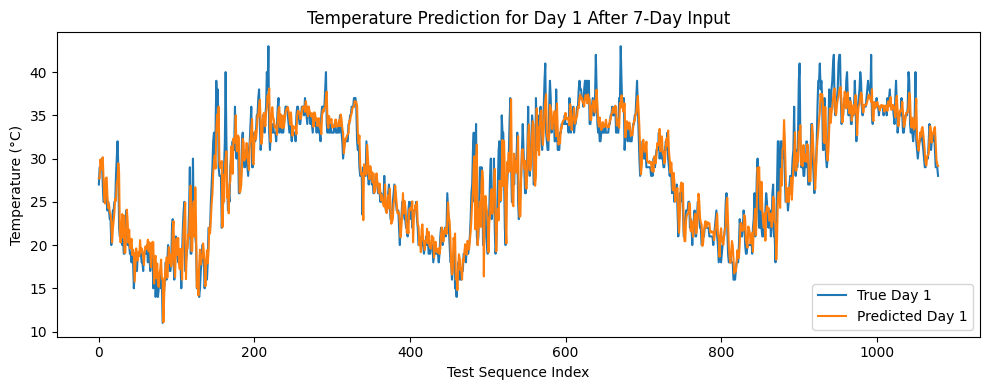

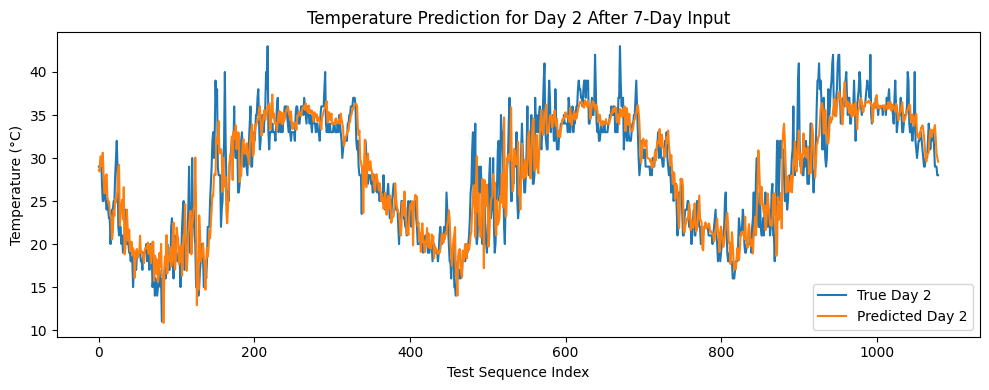

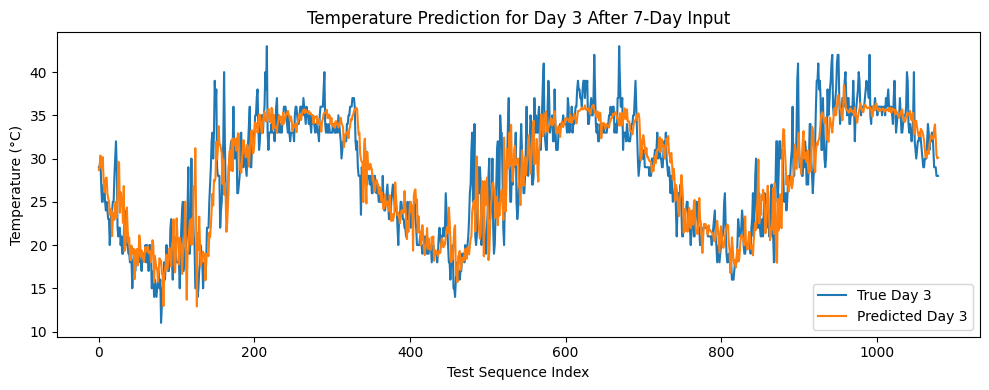

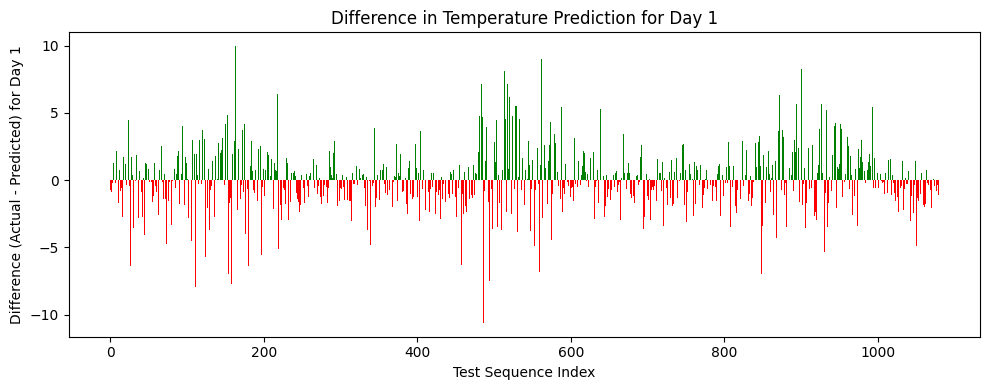

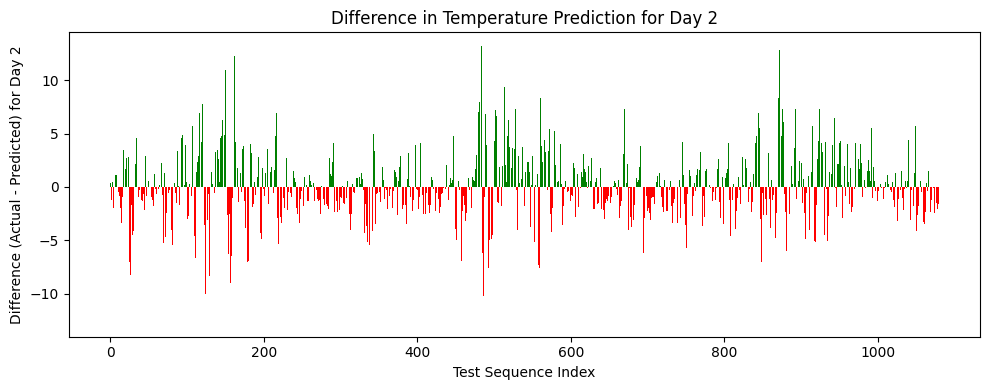

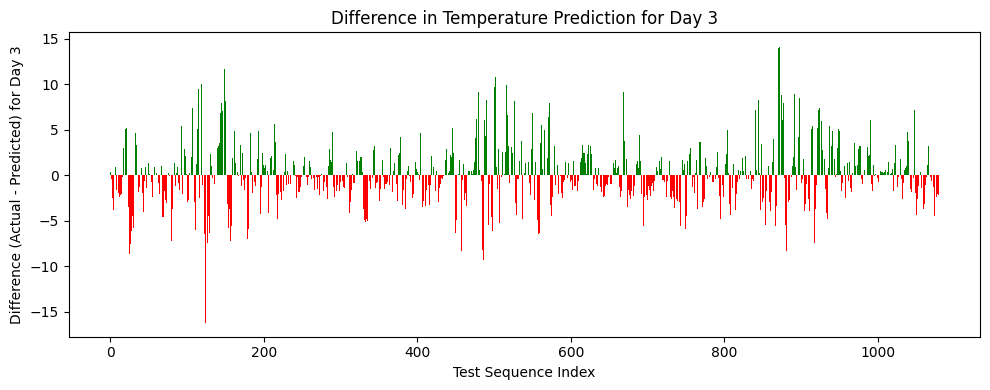


Metrics for Day 1 Prediction:
R² Score: 0.8844
Mean Squared Error (MSE): 5.2772
Mean Absolute Error (MAE): 1.6768
Root Mean Squared Error (RMSE): 2.2972

Metrics for Day 2 Prediction:
R² Score: 0.7919
Mean Squared Error (MSE): 9.5037
Mean Absolute Error (MAE): 2.2651
Root Mean Squared Error (RMSE): 3.0828

Metrics for Day 3 Prediction:
R² Score: 0.7542
Mean Squared Error (MSE): 11.2248
Mean Absolute Error (MAE): 2.4474
Root Mean Squared Error (RMSE): 3.3503


In [26]:
for day in range(prediction_length):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv[:, day], label=f'True Day {day+1}')
    plt.plot(y_pred_inv[:, day], label=f'Predicted Day {day+1}')
    plt.xlabel('Test Sequence Index')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Prediction for Day {day+1} After {sequence_length}-Day Input')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Step 6: Difference bar chart ---

diff = y_test_inv - y_pred_inv
for day in range(prediction_length):
    plt.figure(figsize=(10, 4))
    colors = np.where(diff[:, day] >= 0, 'green', 'red')
    for i in range(len(diff)):
        plt.bar(i, diff[i, day], color=colors[i])
    plt.xlabel('Test Sequence Index')
    plt.ylabel(f'Difference (Actual - Predicted) for Day {day+1}')
    plt.title(f'Difference in Temperature Prediction for Day {day+1}')
    plt.tight_layout()
    plt.show()

# --- Step 7: Evaluation metrics ---
r2_scores = []
mse_scores = []
mae_scores = []
rmse_scores = []

for day in range(prediction_length):
    r2 = r2_score(y_test_inv[:, day], y_pred_inv[:, day])
    mse = mean_squared_error(y_test_inv[:, day], y_pred_inv[:, day])
    mae = mean_absolute_error(y_test_inv[:, day], y_pred_inv[:, day])
    rmse = np.sqrt(mse)

    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"\nMetrics for Day {day+1} Prediction:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [23]:
# Save the trained model
model.save('model_seq7_pre3.keras')

# Save the training history
np.save('history_seq7_pre3.npy', history.history)

print("Model and training history saved successfully.")

Model and training history saved successfully.


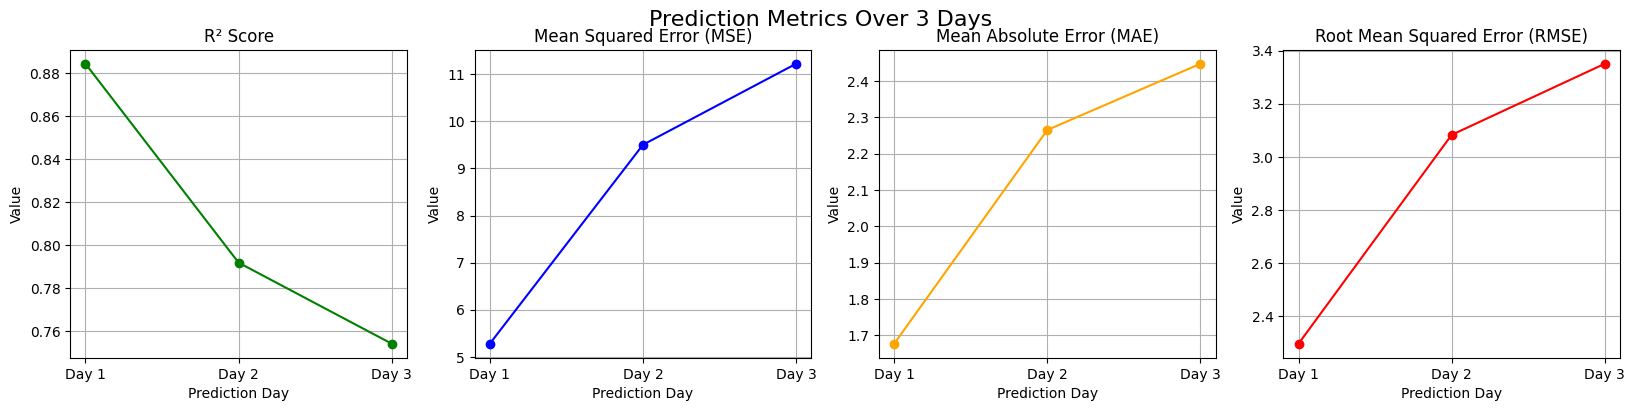

In [29]:
import matplotlib.pyplot as plt

# Metrics data
days = ['Day 1', 'Day 2', 'Day 3']


# Create 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# R² Score (zoomed in between 0.8 and 1.0)
axes[0].plot(days, r2_scores, marker='o', color='green')
axes[0].set_title('R² Score')
axes[0].grid(True)

# MSE
axes[1].plot(days, mse_scores, marker='o', color='blue')
axes[1].set_title('Mean Squared Error (MSE)')
axes[1].grid(True)

# MAE
axes[2].plot(days, mae_scores, marker='o', color='orange')
axes[2].set_title('Mean Absolute Error (MAE)')
axes[2].grid(True)

# RMSE
axes[3].plot(days, rmse_scores, marker='o', color='red')
axes[3].set_title('Root Mean Squared Error (RMSE)')
axes[3].grid(True)

# Shared axis labels
for ax in axes:
    ax.set_xlabel('Prediction Day')
    ax.set_ylabel('Value')

plt.suptitle('Prediction Metrics Over 3 Days', fontsize=16)
plt.show()


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,661 (123.68 KB)

 Trainable params: 10,553 (41.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,108 (82.46 KB)